<a href="https://colab.research.google.com/github/lharikumar/OpenAI_FunctionCalling/blob/main/ConvertNLQueries_FC_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pre-requisites:**

*   Get the OpenAI API key at https://platform.openai.com/account/api-keys
*  API used to get the data is https://datausa.io/api/data?drilldowns=Nation&measures=Population
Response from the API:
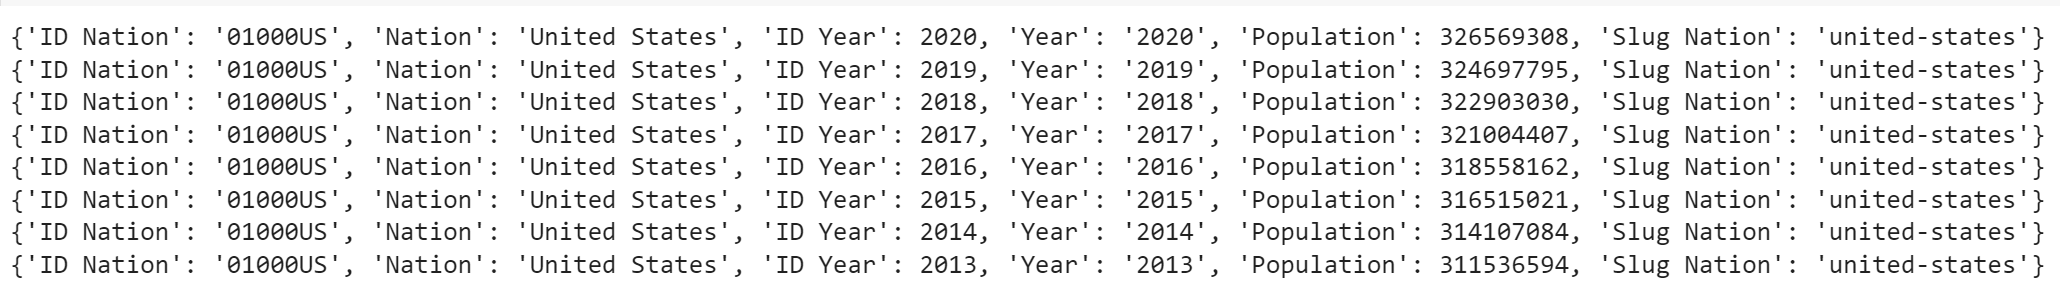



**Note:**

*   Store the OpenAI API key as an environment variable. Never use them directly in the code

In [1]:
!pip install -qU python-dotenv openai

In [2]:
import os
import dotenv
import openai
import requests
import json

In [3]:
dotenv.load_dotenv('/content/env_files/.env')
openai.api_key = os.getenv('OPENAI_API_KEY')

# Converting natural language into API calls

## Define the API Call

In [4]:
def get_population_data_from_api(start_year, end_year):
  url = "https://datausa.io/api/data?drilldowns=Nation&measures=Population"

  print(start_year)
  print(end_year)
  payload = {}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)
  return_json = []
  json_array = json.loads(response.text)
  for item in json_array["data"]:
        if int(item.get("Year")) >= int(start_year) and int(item.get("Year")) <= int(end_year):
          return_json.append({"Population": item.get("Population"), "Year": item.get("Year")})
  return json.dumps(return_json)

In [5]:
fn_response = get_population_data_from_api("2015", "2019")
fn_response

2015
2019


'[{"Population": 324697795, "Year": "2019"}, {"Population": 322903030, "Year": "2018"}, {"Population": 321004407, "Year": "2017"}, {"Population": 318558162, "Year": "2016"}, {"Population": 316515021, "Year": "2015"}]'

# OpenAI Function Calling

## Step 1 - Call the model with functions and the user’s input

In [6]:
messages = [{"role": "user", "content": "What is the year wise population of United States in the second half of last decade?"}]

In [7]:
functions = [
    {
      "name": "get_population_data_from_api",
      "description": "Get the population of a country between the years specified",
      "parameters": {
          "type" : "object",
          "properties": {
              "start_year": {
                  "type": "string",
                  "description": "Starting year for which population is requested"
              },
              "end_year": {
                   "type": "string",
                   "description": "Ending year for which population is requested"
              }
          },
          "required": ["start_year", "end_year"],
      }
    }
]

In [8]:
available_functions = {
    "get_population_data_from_api": get_population_data_from_api,
}

In [9]:
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions,
    function_call='auto'
)

## Step 2 - Use the model response to call your API

In [10]:
response_msg = response.choices[0].message
if response_msg.get('function_call'):
  function_name = response_msg["function_call"]["name"]
  function_to_call = available_functions[function_name]
  function_args = json.loads(response_msg["function_call"]["arguments"])
  function_response = function_to_call(
      start_year = function_args.get('start_year'),
      end_year = function_args.get('end_year'))

2015
2019


In [11]:
print(response_msg)

{
  "role": "assistant",
  "content": null,
  "function_call": {
    "name": "get_population_data_from_api",
    "arguments": "{\n\"start_year\": \"2015\",\n\"end_year\": \"2019\"\n}"
  }
}


In [12]:
print(function_response)

[{"Population": 324697795, "Year": "2019"}, {"Population": 322903030, "Year": "2018"}, {"Population": 321004407, "Year": "2017"}, {"Population": 318558162, "Year": "2016"}, {"Population": 316515021, "Year": "2015"}]


## Step 3 - Send the response back to the model to summarize

In [13]:
messages.append(response_msg)
messages.append({
    "role": "function",
    "name": function_name,
    "content": function_response
})
response_to_user = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages=messages,
        )

In [14]:
response_to_user

<OpenAIObject chat.completion id=chatcmpl-7Zn5QvkozMHPtxqF5qpGCBFgzepmF at 0x7f6ff2a03920> JSON: {
  "id": "chatcmpl-7Zn5QvkozMHPtxqF5qpGCBFgzepmF",
  "object": "chat.completion",
  "created": 1688764524,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "The year-wise population of the United States in the second half of the last decade (from 2015 to 2019) is as follows:\n\n- 2015: 316,515,021\n- 2016: 318,558,162\n- 2017: 321,004,407\n- 2018: 322,903,030\n- 2019: 324,697,795"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 139,
    "completion_tokens": 89,
    "total_tokens": 228
  }
}